In [1]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import csv
import sys
import glob
from netCDF4 import Dataset

from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
import mpl_toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/noc/users/am8e13/Python/')
from python_functions import *
import cmocean
import random
import calendar
import pickle


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
grid = grid_read(18)

/noc/users/am8e13/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:287: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


In [7]:
grid3 = grid_read(36)

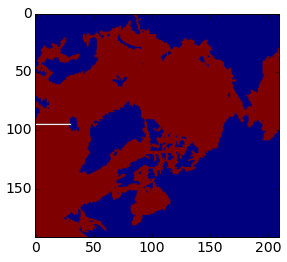

In [68]:
aaaa = np.array(grid3['HFacC'])
aaaa[0,95,0:31] = np.nan

plt.imshow(aaaa[0,:,:])

In [3]:
pert_const = RunRead()
pert_const.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_const/results/')

In [4]:
pert_bench = RunRead()
pert_bench.getPath('/hpcdata/scratch/am8e13/arctic420x384/experiments/exp_bench/results/')

In [3]:
def fluxesCalculation_allin(run,times):
    kdic = {36:1,18:2,9:4}
    kk = kdic[run.res]

    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results'+str(run.res)+'km/grid.nc','r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    drf = file2read.variables['drF']
    drf = drf[:]*1
    rA = file2read.variables['rA']
    rA = rA[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dydx = np.zeros_like(hfacc)
    for k in range(len(drf)):
        dydx[k,:,:] = drf[k]*rA*hfacc[k,:,:]
    Area_x = dydx/dxF
    Area_y = dydx/dyF
    Area_x[hfacc==0]=np.nan
    Area_y[hfacc==0]=np.nan
    
    coords = {'Fram': [58,80,76,76], 'Fram1' : [55,85,78,78] , 'Fram2' : [60,83,72,72] , \
              'Denmark': [100,100,37,48] , 'Bering' : [80,89,178,178] , 'Davis' : [113,135,75,75] ,\
              'Davis1' : [135,135,52,73] , 'Davis2' : [113,135,75,75],\
             'Norwice' : [50,95,15,15], 'Norwice2' : [60,95,25,25],'Scotice' : [89,89,10,31],\
              'Scotice1' : [91,91,10,31],'Scotice2' : [93,93,10,31],'Scotice3' : [95,95,10,31]} 
    ax_d = {'Fram': 3, 'Fram1' : 3 , 'Fram2' : 3 , 'Denmark': 2 , 'Bering' : 3 , \
            'Davis' : 3 , 'Davis1' : 2 , 'Davis2' : 3, 'Norwice': 3, 'Norwice2' : 3,'Scotice':2,'Scotice1':2,\
            'Scotice2':2,'Scotice3':2}
    vel = {'Fram': 'U', 'Fram1' : 'V' , 'Fram2' : 'V' , 'Denmark': 'U' , \
             'Bering' : 'V' , 'Davis' : 'U' , 'Davis1' : 'U' , 'Davis2' : 'U','Norwice':'V','Norwice2':'V',\
          'Scotice':'U','Scotice1':'U','Scotice2':'U','Scotice3':'U'}
    
    def coord_calc(coord):
        if coord[0] == coord[1]:
            coord[0] = coord[0]*kk
            coord[1] = coord[0]+1
            coord[2] = coord[2]*kk
            coord[3] = coord[3]*kk
        elif coord[2] == coord[3]:
            coord[0] = coord[0]*kk
            coord[1] = coord[1]*kk
            coord[2] = coord[2]*kk
            coord[3] = coord[2]+1
        return coord

    run.fluxes2 = {}
    file2read = netcdf.NetCDFFile('/scratch/general/am8e13/results18km/grid.nc','r')
    mask = file2read.variables['HFacC']
    mask = mask[:]*1
    mask = np.tile(mask,(len(times),1,1,1))
    
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                'Norwice','Norwice2','Scotice','Scotice1','Scotice2','Scotice3']:
        coord = coords[var]
        coord = coord_calc(coord)
        run.fluxes2[var] = {'Flux' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxInSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxOutSum' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxS' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumS' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxT' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumT' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxFW' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxFW1' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumFW1' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxOverFlow' : np.zeros_like(mask[:,:,coord[0]:coord[1],coord[2]:coord[3]]),\
                            'FluxSumOverFlow' : np.zeros_like(mask[:,0,0,0]),\
                            'FluxTop' : [], 'FluxMid' : [] , 'FluxBot' : [], \
                            'FluxTopS' : [], 'FluxMidS' : [] , 'FluxBotS' : [], \
                            'FluxTopT' : [], 'FluxMidT' : [] , 'FluxBotT' : []}
        
    S0 = 34.8
    rho0 = 1027.8

    for t,tt in enumerate(times):
        file2read = netcdf.NetCDFFile(run.path+'state.nc','r')
        S = file2read.variables['S']
        S = S[tt]*1
        T = file2read.variables['Temp']
        T = T[tt]*1
        vels = {}
        vels['U'] = file2read.variables['U']
        vels['U'] = vels['U'][tt]*1
        vels['V'] = file2read.variables['V']
        vels['V'] = vels['V'][tt]*1
        
        days = file2read.variables['T']
        days = days[tt]*1
        
        if t == 0:
            years = [0]
            days0 = days
        else:
            years.append((days - days0)/float(60*60*24*360)) 
            
        tmp1 = np.ones_like(mask[:,:,:,:])
        tmp1[:,S>S0] = 0
        
        tmp = np.ones_like(mask[:,:,:,:])
        tmp[:,31:,:,:] = 0
        
        tmpof = np.zeros_like(mask[:,:,:,:])
        tmpof[:,rhop(S,T)>rho0] = 1
        
        for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                    'Norwice','Norwice2','Scotice','Scotice1','Scotice2','Scotice3']:
            coord = coords[var]
            coord = coord_calc(coord)

            run.fluxes2[var]['Flux'][t,:,:] = (vels[vel[var]][:,coord[0]:coord[1],coord[2]:coord[3]]*\
                    Area_y[:,coord[0]:coord[1],coord[2]:coord[3]]/10**6)
            run.fluxes2[var]['FluxSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,:,:]))
            run.fluxes2[var]['FluxInSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]>0]))
            run.fluxes2[var]['FluxOutSum'][t] = np.nansum(np.nansum(run.fluxes2[var]['Flux'][t,run.fluxes2[var]['Flux'][t,:,:]<0]))
            run.fluxes2[var]['FluxT'][t,:,:] = np.tile(run.fluxes2[var]['Flux'][t,:,:]*\
                                                T[:,coord[0]:coord[1],coord[2]:coord[3]],(1,1,1,1))
            run.fluxes2[var]['FluxSumT'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxT'][t,:,:]))
            run.fluxes2[var]['FluxS'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                                                S[:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumS'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxS'][t,:,:])) 
            run.fluxes2[var]['FluxFW'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - S[:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW'][t,:,:]))                 
            run.fluxes2[var]['FluxFW1'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*\
                    (1 - S[:,coord[0]:coord[1],coord[2]:coord[3]]/S0)*tmp1[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumFW1'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxFW1'][t,:,:]))   
            run.fluxes2[var]['FluxOverFlow'][t,:,:] = run.fluxes2[var]['Flux'][t,:,:]*tmpof[t,:,coord[0]:coord[1],coord[2]:coord[3]]
            run.fluxes2[var]['FluxSumOverFlow'][t] = np.nansum(np.nansum(run.fluxes2[var]['FluxOverFlow'][t,:,:]))  
            
        if tt % 10 == 0:
            print 'We are at iteration {}'.format(tt)
    
    for var in ['Fram','Fram1','Fram2','Denmark','Bering','Davis','Davis1','Davis2',\
                'Norwice','Norwice2','Scotice','Scotice1','Scotice2','Scotice3']:
        for flux in ['Flux','FluxT','FluxS','FluxFW','FluxFW1','FluxOverFlow']:
            run.fluxes2[var][flux] = np.squeeze(run.fluxes2[var][flux],axis=ax_d[var])
    run.years = np.array(years)

In [73]:
def read_snap(run,time):
    run.snap = []
    file2read = netcdf.NetCDFFile(run.path+'state.nc','r')
    for var in ['S','Temp','V','U']:
        Temp=file2read.variables[var]    
        run.data[var]=Temp[time]*1
    
        print 'read snap for '+var
    
    run.data['T'] = run.data['Temp'] 
    run.data['rhop'] = np.zeros_like(run.data['S'])
    
    for t in range(run.data['S'].shape[0]):
        run.data['T'][t,grid['HFacC'] == 0] = np.nan
        run.data['S'][t,grid['HFacC'] == 0] = np.nan
        run.data['V'][t,grid['HFacC'] == 0] = np.nan
        run.data['U'][t,grid['HFacC'] == 0] = np.nan
        run.data['Temp'][t,grid['HFacC'] == 0] = np.nan
        run.data['rhop'][t,:,:,:] = rhop(run.data['S'][t,:,:,:],run.data['T'][t,:,:,:])
    print 'read snap for rhop'
        
read_snap(pert_const,[1+12*5, 3+12*5, 6+12*5,18+12*5,27+12*5,48+12*5])
read_snap(pert_bench,[1+12*5, 3+12*5, 6+12*5,18+12*5,27+12*5,48+12*5])

pert_const.baroCalc()
pert_bench.baroCalc()

read snap for S
read snap for Temp
read snap for V
read snap for U
read snap for rhop
calc baro
read snap for S
read snap for Temp
read snap for V
read snap for U
read snap for rhop
calc baro


/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:220: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


In [93]:
dpires = 300

In [101]:
def strait_flux_norwice(data_pert,data_diff,times,diff=True):
    ind = 0
    
    variables = ['S','T','U','rhop']
    vartitle = {'S':'psu' , 'T' : r'$^{\circ}$C' , 'U': 'm/s' , 'rhop' : r'$kg/m^3$'}
    verttit = {'S':'Salinity','T':'Temperature','U':'Velocity','rhop':'Density'}
    if diff:
        cmaps = {'S' : cmocean.cm.vort, 'T' : cmocean.cm.vel , 'U' : cmocean.cm.freesurface, \
                 'rhop' : matplotlib.cm.RdBu}    
        vmins = {'S' : -1, 'T' :-4 , 'U' : -0.3 , 'rhop' : -0.5 }
        vmaxs = {'S' : 1, 'T' : 4, 'U' : 0.3 , 'rhop' : 0.5}
        difftitle = 'diff'
    else:
        cmaps = {'S' : cmocean.cm.salinity, 'T' : cmocean.cm.temperature , 'U' : matplotlib.cm.seismic,\
                'rhop' : cmocean.cm.density}
        vmins = {'S' : 34.5, 'T' : 4 , 'U' : -0.5 , 'rhop' : 1026.5}
        vmaxs = {'S' : 35.5, 'T' : 11, 'U' : 0.5, 'rhop' : 1029.5}
        difftitle = ''
    grid = grid_read(data_pert.res)
    
    kres = {36:1,18:2,9:4}
    k = kres[data_pert.res]
    fig, axes = plt.subplots(len(variables)+1,len(times))#,sharex='col', sharey='row')        
    for var in variables:
        for t,tt in zip(times,[0.08,0.25,0.5,1.5,2.25,4.0]):
            cmap = cmaps[var]
            cmap.set_bad('grey') 
            if diff:
                toplot = data_pert.data[var][t,0:36,95*k,0*k:31*k] - data_diff.data[var][t,0:36,95*k,0*k:31*k]
            else:
                toplot = data_pert.data[var][t,0:36,95*k,0*k:31*k]
            imdata = np.ma.masked_invalid(toplot)
            
            CS = axes.flat[ind].pcolormesh(grid['XC'][95*k,0*k:31*k],data_pert.Z[0:36],imdata,
                    vmin=vmins[var],vmax=vmaxs[var],cmap = cmap,)   
            axes.flat[ind].set_title(var+' at '+str(tt)+' yrs',fontsize=16)
            axes.flat[ind].title.set_fontsize('14')
            axes.flat[ind].tick_params(axis='both', which='major', labelsize=14) 
            axes.flat[ind].set_xticks([-18,-15,-12])# 58N 4W 64N, -15W

            if ind%len(times)==0:
                axes.flat[ind].set_ylabel(verttit[var]+'\nDepth (m)',fontsize=16)
            else: 
                axes.flat[ind].get_yaxis().set_visible(False)
            if ind/len(times)-1==2:
                #axes.flat[ind].set_xlabel(r'Lon ($^{\circ}$)',fontsize=16)
                axes.flat[ind].set_xlabel(r'',fontsize=16)
            else:
                axes.flat[ind].get_xaxis().set_visible(False)
            ind += 1
        div = make_axes_locatable(axes.flat[ind-1])
        cax = div.append_axes("right", size="10%", pad=0.05)
        cbar = plt.colorbar(CS, cax=cax, format="%.2g")
        cbar.set_label(vartitle[var], size=16)
        cbar.ax.tick_params(labelsize=14)
        
    lat_ts=90.0 ; lat_0=61.0 ; lon_0=-9.0 ;sgn=1
    width=1600000. ; height=1600000.0
    
    vimin = -20 ; vimax = 20
    kres = {36:1,18:2,9:9}
    kk = kres[data_pert.res]
    cmap=matplotlib.cm.seismic
    
    for t,tt in zip(times,[0.08,0.25,0.5,1.5,2.25,4.0]):
        m = Basemap(ax=axes.flat[ind],width=width,height=height,resolution='l',\
                    projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='black')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='grey',lake_color='black')
        x,y=m(data_pert.lon,data_pert.lat)
        if diff:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]-data_diff.psi[t,0*kk:192*kk,0*kk:210*kk]
        else:
            datam = data_pert.psi[t,0*kk:192*kk,0*kk:210*kk]
        sitm = np.ma.masked_where(np.isnan(datam),datam)
        CS=m.pcolormesh(x,y,sitm,cmap=cmap,vmin=vimin,vmax=vimax)
        m.drawparallels(np.arange(-80.,81.,15.))
        m.drawmeridians(np.arange(-180.,181.,30.))
        axes.flat[ind].set_title('Pert at '+str(tt)+'yrs',fontsize=16)        
        if ind%len(times)==0:
            axes.flat[ind].set_ylabel('Barotropic\nstreamfunction',fontsize=16)
        ind += 1
    div = make_axes_locatable(axes.flat[ind-1])
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(CS, cax=cax,)
    cbar.set_label('Sv', size=16)
    cbar.ax.tick_params(labelsize=14)
        
    fig.suptitle("Iceland Scotland Ridge "+difftitle+" transect (Ice <---> Sc)",x=1.,y=3.2,fontsize=18)      
    fig.subplots_adjust(right=2.1,top=3.)
    fig.savefig('/noc/users/am8e13/Figures/perturbation_scotice'+difftitle,dpi=dpires, bbox_inches='tight')



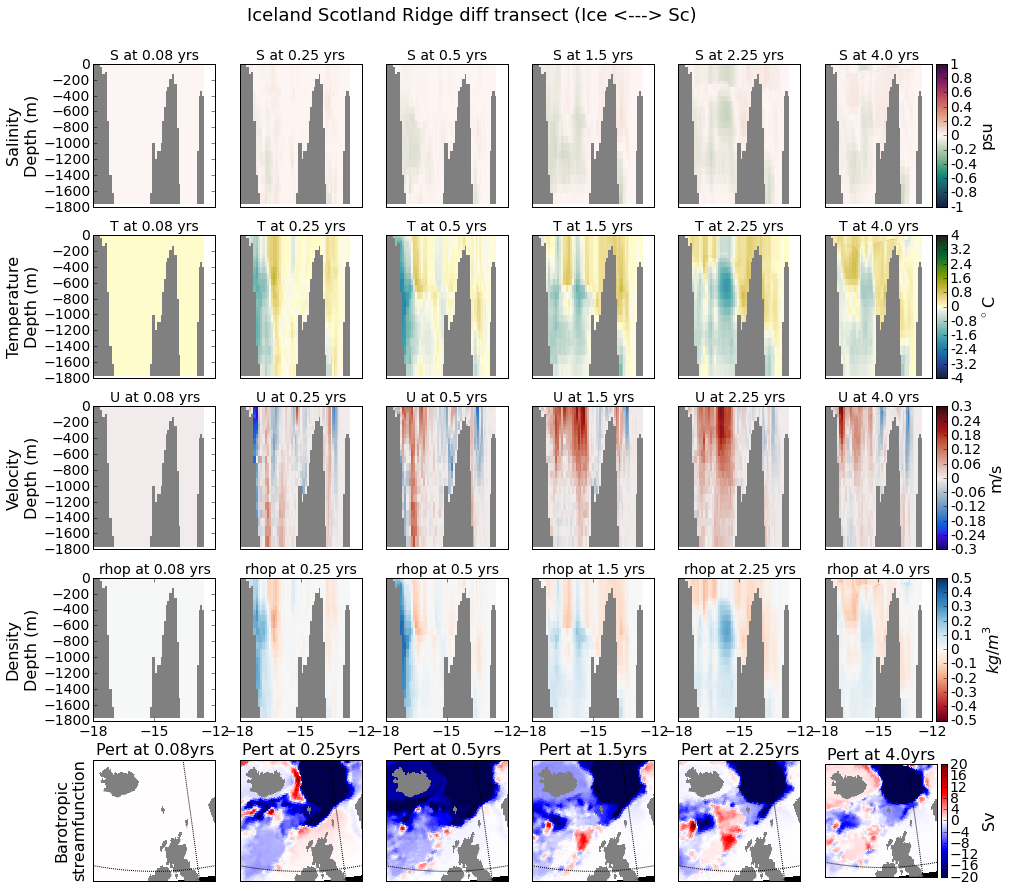

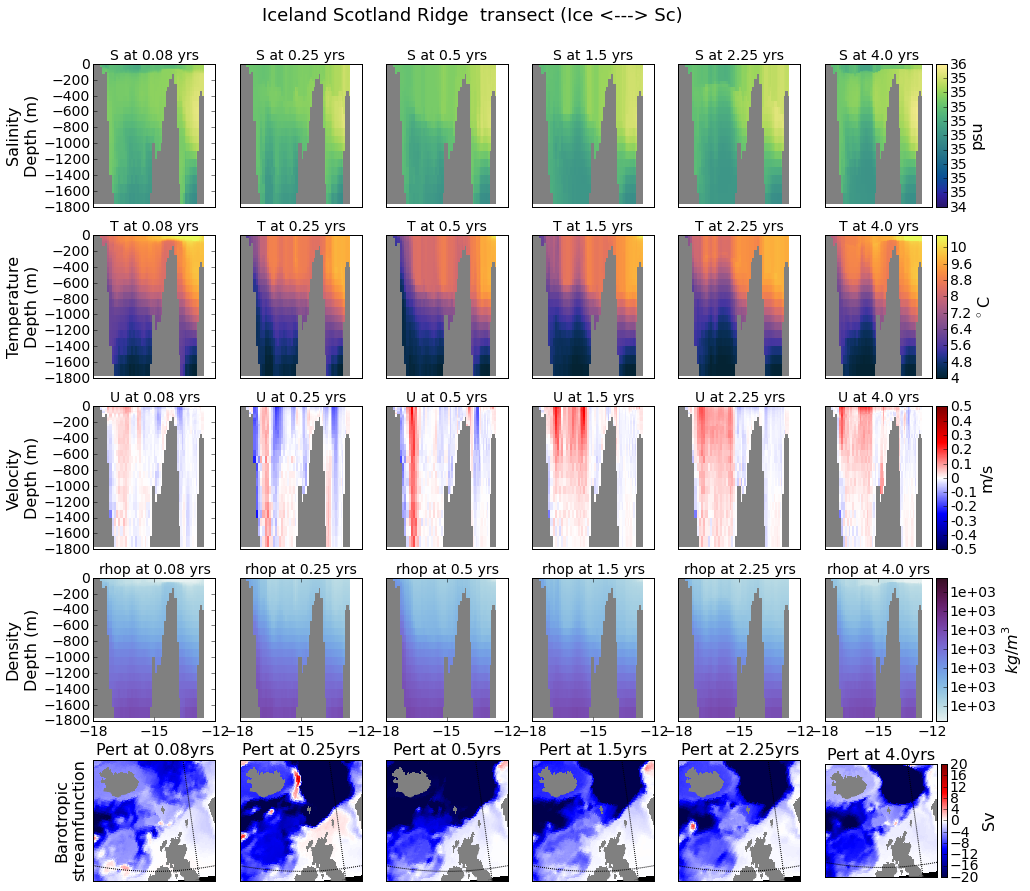

In [102]:
strait_flux_norwice(pert_const,pert_bench,times = [0,1,2,3,4,5],diff=True)
strait_flux_norwice(pert_const,pert_bench,times = [0,1,2,3,4,5],diff=False)

In [6]:
f = open('/scratch/general/am8e13/pert_pickles/pert_const_18')
pert_const= pickle.load(f)
f.close

f = open('/scratch/general/am8e13/pert_pickles/pert_bench_18')
pert_bench= pickle.load(f)
f.close

<function close>

In [3]:
f = open('/scratch/general/am8e13/pert_pickles/pert_const_flux')
pert_const= pickle.load(f)
f.close

f = open('/scratch/general/am8e13/pert_pickles/pert_bench_flux')
pert_bench= pickle.load(f)
f.close

<function close>

In [48]:
# plot layers
def plot_total_flux1(data_pert,data_diff,loc='Scotice',cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['Flux','FluxFW','FluxT']
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = [loc,loc,loc]
    var_dic = {0:loc,1:loc,2:loc}
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2':'Norwice',\
                  'Scotice' : 'Scotl-Ice','Scotice1' : 'Scotl-Ice',\
                  'Scotice2' : 'Scotl-Ice','Scotice3' : 'Scotl-Ice','Scotice_ave' : 'Scotl-Ice',\
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    if cum:
        cumtit = 'cumulative'
        cumtitle = '_cumulative'
    else:
        cumtit = 'per layer'
        cumtitle = '_layer'
    unit = {'FluxFW' : 'Sv' , 'Flux' : 'Sv' , 'FluxT' : 'TW' }
    iniz = 36
    depth = {0:'0-200' , 1 : '200-1600', 2: '1600-3500'}
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        ind = 0
        for vard in var_dic:
            var = var_dic[vard]
            colormap = matplotlib.cm.jet
            colors = [colormap(i) for i in np.linspace(0, 1,45)]
            if vard  == 0:
                beg = 0
                end = 17
            elif vard == 1:
                beg = 17
                end = 36
            else:
                beg = 36
                end = 44
            for k in range(end,beg,-1):    
                if cum:
                    data = np.nansum(np.nansum((data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux] \
                                               )[:,beg:k,:],axis=2),axis=1)
                else:
                    data = np.nansum((data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,k,:],axis=1)                
                
                if flux == 'FluxT':
                    data = data*1000*4.202/10**6
                    
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)[iniz:-1],color=colors[k])
            if cum & (ax_ind != 8):
                data = np.nansum(np.nansum((
                        data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
                if flux == 'FluxT':
                    data = data*1000*4.202/10**6
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)
                                   [iniz:-1],color='black',label='Total',lw=2)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel(unit[flux],fontsize=16)
            if ax_ind/len(variables)-1==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux] +' at '+ depth[vard]+'m',fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1

    for k in range(0,44,3):
        ax_ind = 8
        data = np.nansum(np.nansum((
                data_pert.fluxes2[var][flux]-data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
        if flux == 'FluxT':
            data = data*1000*4.202/10**6
        axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)
                                   [iniz:-1],color=colors[k],label=int(data_pert.Z[k]))
    data = np.nansum(np.nansum((
                data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
    if flux == 'FluxT':
        data = data*1000*4.202/10**6  
    axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-5,runningMeanFast(data,12)
                           [iniz:-1],color='black',label='Total',lw=2)
    plt.legend(bbox_to_anchor=(1.05, 2), loc=6, borderaxespad=0.,fontsize=16)
    
    axes.flat[6].set_xlabel('Years',fontsize=16)
    axes.flat[7].set_xlabel('Years',fontsize=16)
    axes.flat[8].set_xlabel('Years',fontsize=16)
    
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("{} ridge fluxes".format(var_titles[loc]),x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/scotice_fluxes'+cumtitle,dpi=dpires, bbox_inches='tight')

#plot_total_flux(pert_const,pert_bench,cum=False)

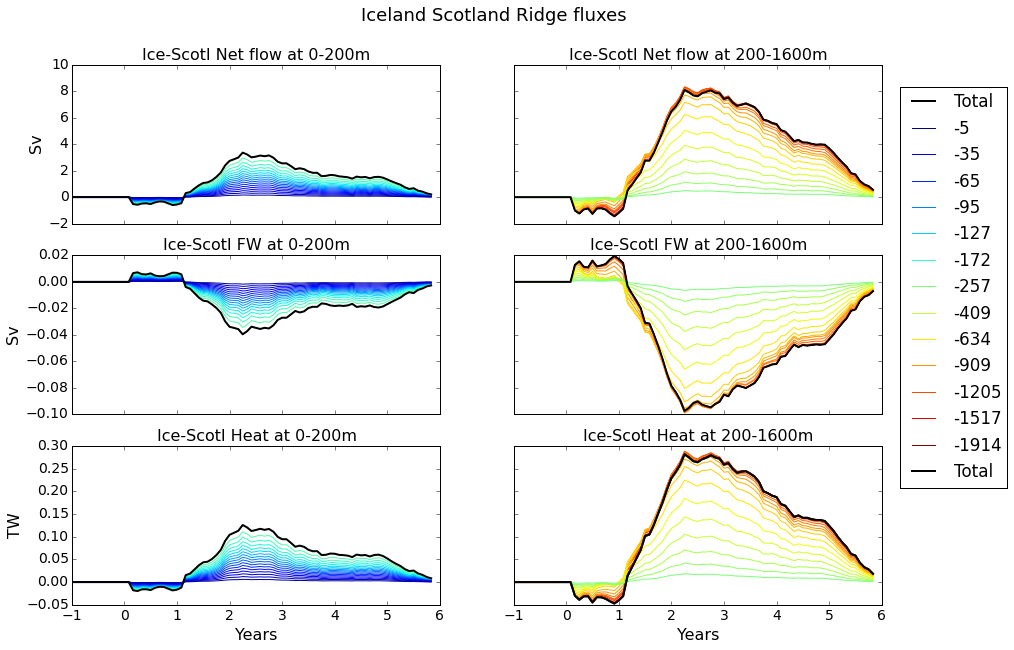

In [14]:
# plot layers
def plot_total_flux1_scotice(data_pert,data_diff,loc='Scotice_ave',cum=True,row=2,col=2):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['Flux','FluxFW','FluxT']#'FluxOverFlow',
    #variables = ['Fram','Barents','Davis','Denmark']
    variables = [loc,loc]
    var_dic = {0:loc,1:loc}
    flux_titles = {'FluxFW' : 'FW','FluxFW1' : 'FW<35','FluxS' : 'S', 'FluxT':'Heat', \
                   'FluxIn' : 'Inflow','FluxOut' : 'Outflow' , 'Flux' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2':'Norwice',\
                  'Scotice' : 'Scotl-Ice','Scotice1' : 'Scotl-Ice',\
                  'Scotice2' : 'Scotl-Ice','Scotice3' : 'Scotl-Ice','Scotice_ave' : 'Ice-Scotl',\
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    
    if cum:
        cumtit = 'cumulative'
        cumtitle = '_cumulative'
    else:
        cumtit = 'per layer'
        cumtitle = '_layer'
    unit = {'FluxFW' : 'Sv' , 'Flux' : 'Sv' , 'FluxT' : 'TW' }
    iniz = 36
    depth = {0:'0-200' , 1 : '200-1600'}
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        ind = 0
        for vard in var_dic:
            var = var_dic[vard]
            colormap = matplotlib.cm.jet
            colors = [colormap(i) for i in np.linspace(0, 1,37)]
            if vard  == 0:
                beg = 0
                end = 17
            elif vard == 1:
                beg = 17
                end = 36
            for k in range(end,beg,-1):    
                if cum:
                    data = np.nansum(np.nansum((data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux] \
                                               )[:,beg:k,:],axis=2),axis=1)
                else:
                    data = np.nansum((data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,k,:],axis=1)
                if flux == 'FluxT':
                    data = data*1000*4.202/10**6
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-4,runningMeanFast(data,12)[iniz:-1],color=colors[k])
            if cum & (ax_ind != 8):
                data = np.nansum(np.nansum((
                        data_pert.fluxes2[var][flux] - data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
                if flux == 'FluxT':
                    data = data*1000*4.202/10**6
                axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-4,runningMeanFast(data,12)
                                   [iniz:-1],color='black',label='Total',lw=2)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel(unit[flux],fontsize=16)
            if ax_ind/len(variables)-1==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux] +' at '+ depth[vard]+'m',fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1

    for k in range(0,37,3):
        ax_ind = 5 
        data = np.nansum(np.nansum((
                data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
        if flux == 'FluxT':
            data = data*1000*4.202/10**6        
        axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-4,runningMeanFast(data,12)
                                   [iniz:-1],color=colors[k],label=int(data_pert.Z[k]))
    data = np.nansum(np.nansum((
                data_pert.fluxes2[var][flux] -  data_diff.fluxes2[var][flux])[:,beg:end,:],axis=2),axis=1)
    if flux == 'FluxT':
        data = data*1000*4.202/10**6       
    axes.flat[ax_ind].plot(data_pert.years[iniz:-1]-4,runningMeanFast(data,12)
                           [iniz:-1],color='black',label='Total',lw=2)
        
    axes.flat[4].set_xlabel('Years',fontsize=16)
    axes.flat[5].set_xlabel('Years',fontsize=16)
    
    plt.legend(bbox_to_anchor=(1.05, 2), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Iceland Scotland Ridge fluxes",x=1.1,y=2.2,fontsize=18)  
    fig.savefig('/noc/users/am8e13/Figures/scotice_fluxes'+cumtitle,dpi=dpires, bbox_inches='tight')

dpires = 300
plot_total_flux1_scotice(pert_const,pert_bench,loc='Scotice_ave')

#plot_total_flux(pert_const,pert_bench,cum=False)

In [49]:
dpires = 300

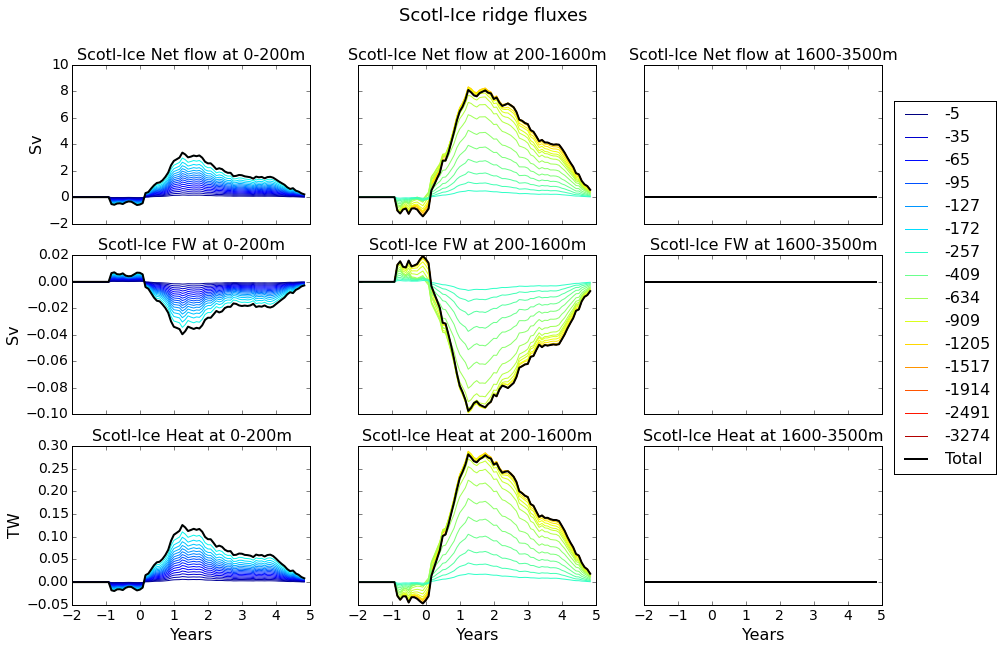

In [50]:
plot_total_flux1(pert_const,pert_bench,loc='Scotice_ave')

In [7]:
fluxesCalculation_allin(pert_const,times = range(0,60,1)+range(61,61+60,1))

We are at iteration 0
We are at iteration 10
We are at iteration 20
We are at iteration 30
We are at iteration 40
We are at iteration 50
We are at iteration 70
We are at iteration 80
We are at iteration 90
We are at iteration 100
We are at iteration 110
We are at iteration 120


/noc/users/am8e13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:91: RuntimeWarning: invalid value encountered in greater
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:92: RuntimeWarning: invalid value encountered in less


In [8]:
f = open('/scratch/general/am8e13/pert_pickles/pert_const_flux', 'w')
pickle.dump(pert_const,f)

In [9]:
fluxesCalculation_allin(pert_bench,times = range(0,60,1)+range(61,61+60,1))

We are at iteration 0
We are at iteration 10
We are at iteration 20
We are at iteration 30
We are at iteration 40
We are at iteration 50
We are at iteration 70
We are at iteration 80
We are at iteration 90
We are at iteration 100
We are at iteration 110
We are at iteration 120


/noc/users/am8e13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:91: RuntimeWarning: invalid value encountered in greater
/noc/users/am8e13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:92: RuntimeWarning: invalid value encountered in less


In [10]:
f = open('/scratch/general/am8e13/pert_pickles/pert_bench_flux', 'w')
pickle.dump(pert_bench,f)

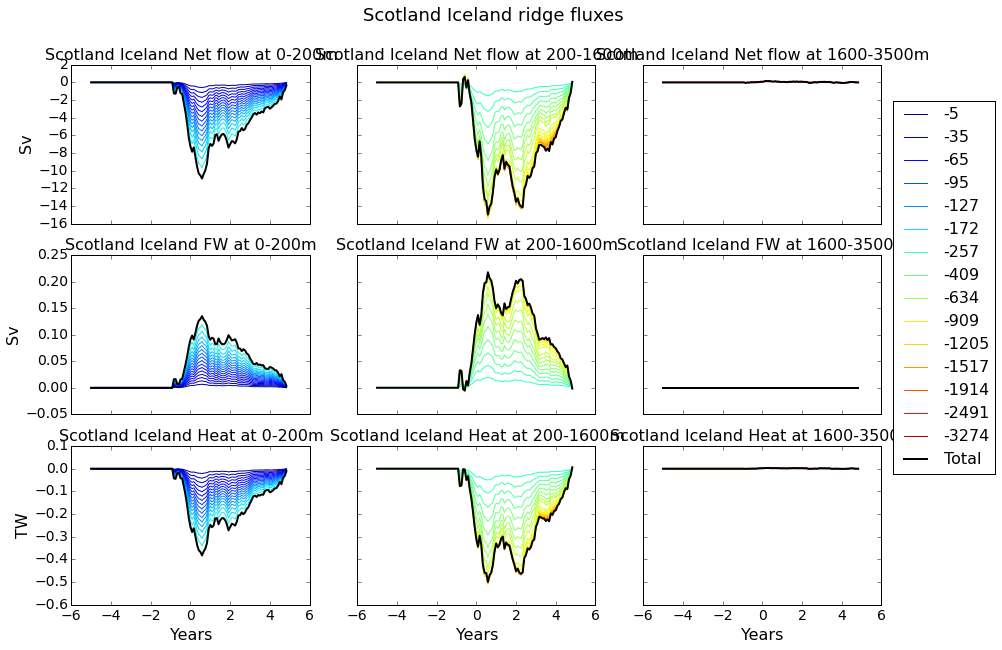

In [11]:
plot_total_flux1(pert_const,pert_bench,loc='Scotice')

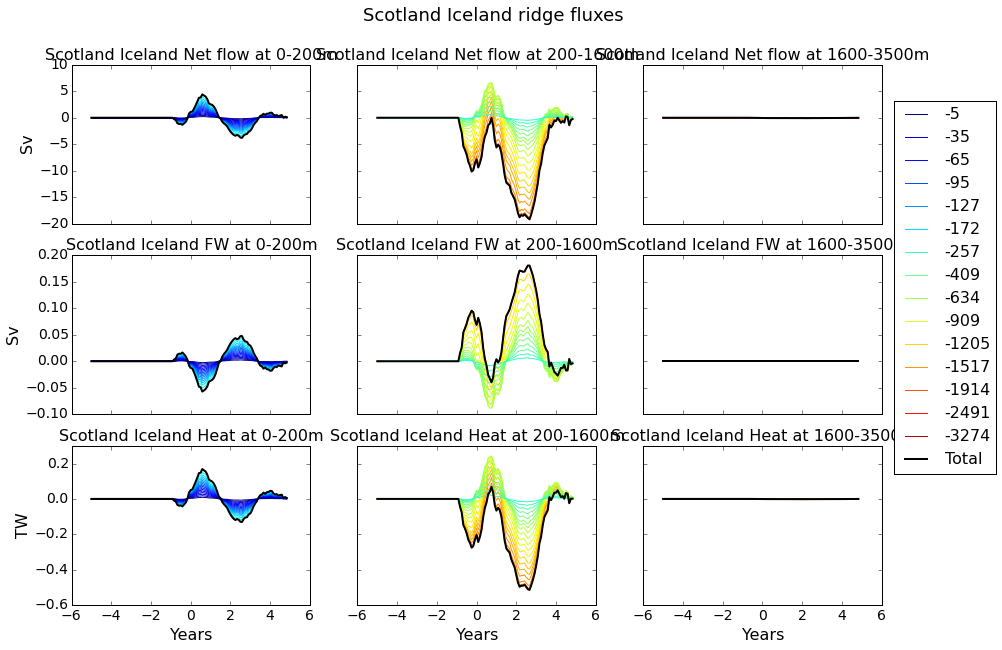

In [12]:
plot_total_flux1(pert_const,pert_bench,loc='Scotice1')

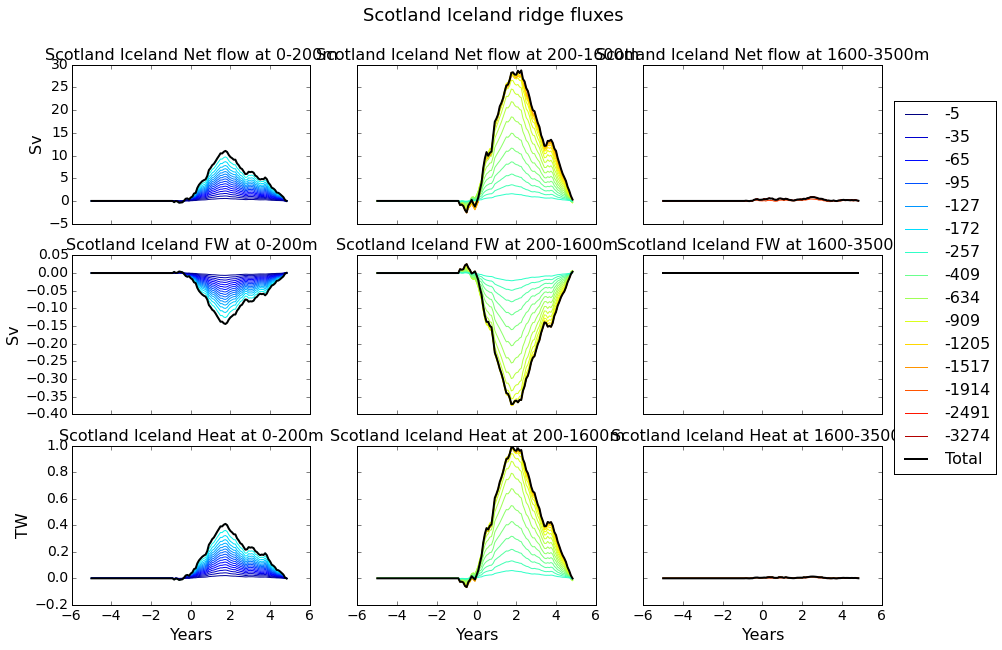

In [13]:
plot_total_flux1(pert_const,pert_bench,loc='Scotice2')

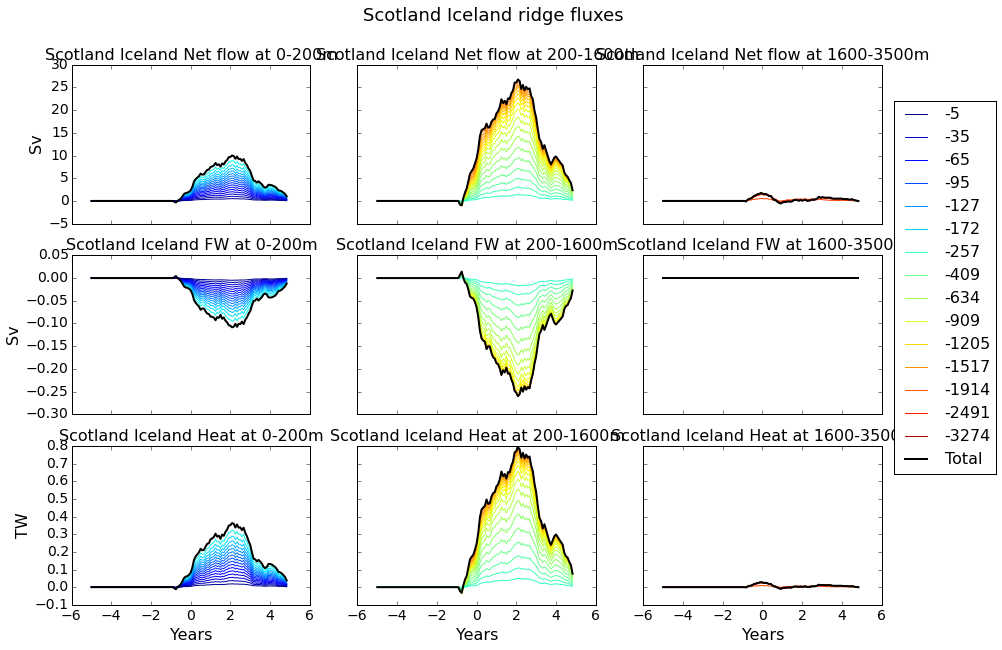

In [14]:
plot_total_flux1(pert_const,pert_bench,loc='Scotice3')

In [4]:
def ave_fluxes(run):
    run.fluxes2['Scotice_ave'] = {}
    for flux in ['FluxSum','FluxSumFW','FluxSumT','Flux','FluxFW','FluxT']:
        run.fluxes2['Scotice_ave'][flux] = (run.fluxes2['Scotice'][flux] + run.fluxes2['Scotice1'][flux] + \
                                        run.fluxes2['Scotice2'][flux] + run.fluxes2['Scotice3'][flux])/4.
ave_fluxes(pert_bench)
ave_fluxes(pert_const)

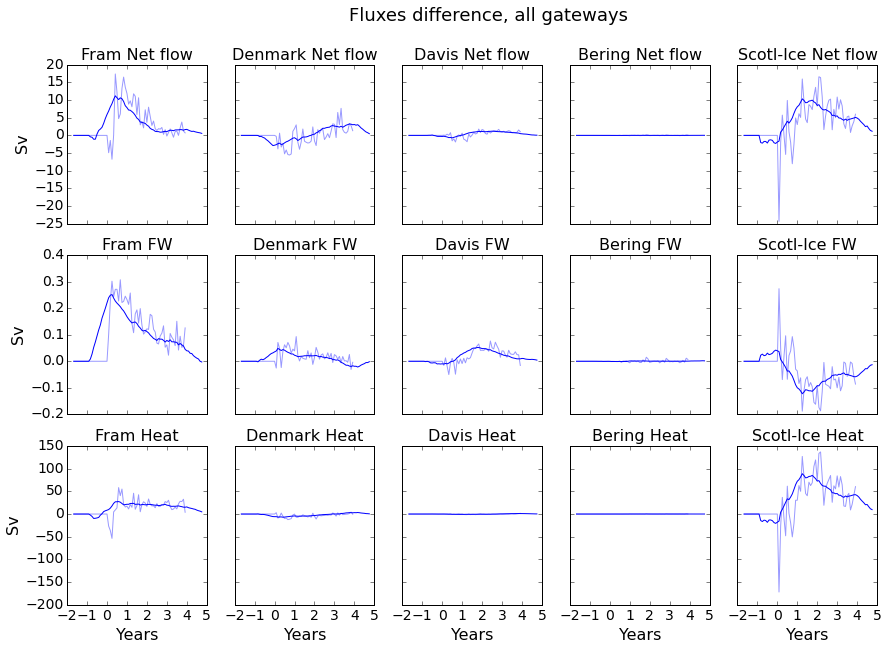

In [32]:
# plot layers
def plot_flux_total_diff(data_pert,data_diff):
    # this function is meant to plot monitor variables   
    ax_ind = 0
    fluxes = ['FluxSum','FluxSumFW','FluxSumT']#'FluxSumFW1',
    variables = ['Fram','Denmark','Davis','Bering','Scotice_ave']#'Norwice','Barents',
    #variables = ['Fram','Denmark']
    flux_titles = {'FluxSumFW' : 'FW','FluxSumFW1' : 'FW<34.8','FluxSumS' : 'S', 'FluxSumT':'Heat', \
                   'FluxInSum' : 'Inflow','FluxOutSum' : 'Outflow' , 'FluxSum' : 'Net flow'}
    var_titles = {'Fram' : 'Fram' , 'Fram1' : 'Fram' , 'Fram2' : 'Fram' , 
                  'Davis': 'Davis' , 'Davis1': 'Davis' , 'Davis2': 'Davis',
                  'Scotice':'Scotl-Ice','Scotice1':'Scotl-Ice','Scotice2':'Scotl-Ice','Scotice3':'Scotl-Ice',
                  'Scotice_ave':'Scotl-Ice',
                 'Denmark' : 'Denmark' , 'Bering' : 'Bering' , 'Norwice' : 'Norwice' ,'Norwice2' : 'Norwice2' ,
                 'Barents' : 'Barents' , 'Barents1' : 'Barents' , 'Barents2' : 'Barents'}
    iniz = 40
    fig, axes = plt.subplots(len(fluxes),len(variables),sharex=True,sharey='row')
    for flux in fluxes:
        for var in variables:  
            if variables == 'Barents':
                data = data_pert.fluxes[var][flux]-data_diff.fluxes[var][flux]
            else:
                data = data_pert.fluxes2[var][flux]-data_diff.fluxes2[var][flux]
            axes.flat[ax_ind].plot(data_pert.years[iniz:-12]-5,data[iniz:-12],alpha=0.4,color='b')
            axes.flat[ax_ind].plot(data_pert.years[iniz:-2]-5,runningMeanFast(data,12)[iniz:-2],color='b')
            axes.flat[ax_ind].set_title(var + flux ,fontsize=16)
            if ax_ind%len(variables)==0:
                axes.flat[ax_ind].set_ylabel('Sv',fontsize=16)
            if ax_ind/len(variables)==2:
                axes.flat[ax_ind].set_xlabel('Years',fontsize=16)
            axes.flat[ax_ind].set_title(var_titles[var]+' '+flux_titles[flux],fontsize=16)
            axes.flat[ax_ind].tick_params(axis='both', which='major', labelsize=14)            
            ax_ind += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
    fig.subplots_adjust(right=2.,top=2.)
    fig.suptitle("Fluxes difference, all gateways",x=1.1,y=2.2,fontsize=18)  
    #fig.savefig('/noc/users/am8e13/Figures/perturbation_flows_allgate',dpi=dpires, bbox_inches='tight')

plot_flux_total_diff(pert_const,pert_bench,)

In [ ]:
ss